# **K2 algorithm** | test of the implementation

Project for *Advanced Statistics for Physics Analysis*, University of Padua, A.Y. 2021/22<br>
**Learning the topology of a Bayesian Network from a database of cases using the K2 algorithm**

**Students** | Francesco Pio Barone, Gianmarco Nagaro Quiroz, Daniele Ninni

***
## **Table of Contents**
1) [**Functions**](#sec1)<br>

2) [**Datasets**](#sec2)<br>
    - 2.A [*CH93*](#sec2.A)<br>
    - 2.B [*ASIA*](#sec2.B)<br>
    - 2.C [*SACHS*](#sec2.C)<br>
    - 2.D [*CHILD*](#sec2.D)<br>
3) [**Comparisons and Results**](#sec3)<br>
    - 3.A [*Bayesian Network Graph Obtention*](#sec3.A)<br>
    - 3.B [*Test on SACHS Dataset*](#sec3.B)<br>
    - 3.C [*Test on ASIA Dataset*](#sec3.C)<br>
    - 3.D [*Comparisons with TABU and HC*](#sec3.D)<br>
***

In [1]:
# load packages
library(tidyverse) |> suppressPackageStartupMessages()
library(ggplot2)   |> suppressPackageStartupMessages()
library(bnlearn)   |> suppressPackageStartupMessages()
library(Rgraphviz) |> suppressPackageStartupMessages()

<a id='sec1'></a>
## **1** - Loading functions from the previous notebook

In [2]:
k2 <- function(dataset, parents.nmax, f, ...) {

        nodes   <- names(dataset)           # node names
        net.dag <- empty.graph(nodes=nodes) # network DAG (Directed Acyclic Graph)

        for (i in 2:length(nodes)) {

            node           <- nodes[i]                  # current node
            previous.nodes <- nodes[1:(i-1)]            # nodes that precede the current node
            parents        <- c()                       # parents of the current node
            P_old          <- f(node, parents, dataset) # old probability
            proceed        <- T
            
            while (proceed & (length(parents) < parents.nmax)) {

                candidates <- setdiff(previous.nodes, parents) # candidate parents of the current node 
                P_new      <- P_old                            # new probability

                for (candidate in candidates) {

                    candidate.score <- f(node, c(parents, candidate), dataset) # candidate parent score

                    if (candidate.score > P_new) {

                        candidates.best <- candidate       # best candidate parent
                        P_new           <- candidate.score

                    }

                }

                if (P_new > P_old) {

                    P_old   <- P_new
                    parents <- c(parents, candidates.best)
                    net.dag <- set.arc(net.dag, from=candidates.best, to=node)

                } else {

                    proceed <- F

                }

            }

        }

        net.score <- score(net.dag, dataset |> mutate_all(as_factor) |> as.data.frame(), ...) # network score

        return(list('dag'=net.dag, 'score'=net.score))

}

In [3]:
k2.iter <- function(dataset, parents.nmax, f, k2, n.iter=1, seed=1, ...) {

    tic <- Sys.time()
    set.seed(seed)

    n.iter     <- max(n.iter, 1)
    best.score <- -Inf

    for (i in 1:n.iter) {

        cat('Running iteration #', i, '...')
        flush.console()

        nodes.order <- if (i == 1) names(dataset) else sample(names(dataset))
        result      <- k2(dataset[nodes.order], parents.nmax, f, ...)

        if (result$score > best.score) {

            best.dag   <- result$dag
            best.score <- result$score
            best.order <- nodes.order

        }

        cat(' DONE\n')
        flush.console()

    }

    toc <- Sys.time()
    cat('\nTotal execution time:', difftime(toc, tic, units='secs'), 's')

    return(list('dag'=best.dag, 'score'=best.score, 'order'=best.order))

}

In [4]:
f <- function(node, parents, dataset) {

    node.nunique <- dataset[node] |>
                        unique() |>
                        nrow()

    contingency_table <- dataset[c(node, parents)] |>
                            table() |>
                            as.data.frame() |>
                            as_tibble() |>
                            filter(Freq > 0)

    numerator <- contingency_table |>
                    mutate(Freq = factorial(Freq)) |>
                    group_by_at(parents) |>
                    summarise(Freq = prod(Freq), .groups='drop_last') |>
                    mutate(Freq = (Freq * factorial(node.nunique - 1))) |>
                    ungroup() |>
                    select(Freq) |>
                    deframe()

    denominator <- contingency_table |>
                    group_by_at(parents) |>
                    summarise(Freq = sum(Freq), .groups='drop_last') |>
                    mutate(Freq = factorial(Freq + node.nunique - 1)) |>
                    ungroup() |>
                    select(Freq) |>
                    deframe()

    dataset.prob <- prod(numerator / denominator)

    return(dataset.prob)

}

In [5]:
log.f <- function(node, parents, dataset) {

    node.nunique <- dataset[node] |>
                        unique() |>
                        nrow()

    contingency_table <- dataset[c(node, parents)] |>
                            table() |>
                            as.data.frame() |>
                            as_tibble() |>
                            filter(Freq > 0)

    A <- 1:(node.nunique - 1) |>
            log() |>
            sum()

    B <- contingency_table |>
            rowwise() |>
            mutate(Freq = ((1:Freq) |> log() |> sum())) |>
            ungroup() |>
            group_by_at(parents) |>
            summarise(Freq = sum(Freq), .groups='drop_last') |>
            ungroup() |>
            select(Freq) |>
            deframe()

    C <- contingency_table |>
            group_by_at(parents) |>
            summarise(Freq = sum(Freq), .groups='drop_last') |>
            ungroup() |>
            rowwise() |>
            mutate(Freq = ((1:(Freq + node.nunique - 1)) |> log() |> sum())) |>
            ungroup() |>
            select(Freq) |>
            deframe()

    dataset.log.prob <- sum(A + B - C)
    
    return(dataset.log.prob)

}

<a id='sec2.A'></a>
### **2.A** *CH93* [[3]](#ref3)

In [6]:
ch93 <- tibble(
            x1 = c(1, 1, 0, 1, 0, 0, 1, 0, 1, 0),
            x2 = c(0, 1, 0, 1, 0, 1, 1, 0, 1, 0),
            x3 = c(0, 1, 1, 1, 0, 1, 1, 0, 1, 0))
ch93

x1,x2,x3
<dbl>,<dbl>,<dbl>
1,0,0
1,1,1
0,0,1
1,1,1
0,0,0
0,1,1
1,1,1
0,0,0
1,1,1


<a id='sec2.B'></a>
### **2.B** *ASIA*

In [7]:
asia <- read_csv('https://www.ccd.pitt.edu/wiki/images/ASIA10k.csv')
head(asia)
asia_net <- k2.iter(dataset=asia, parents.nmax=2, f=log.f, k2=k2, n.iter=5, seed=1, type='bde', iss=10)

Rows: 10000 Columns: 8
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ","
chr (8): asia, tub, smoke, lung, bronc, either, xray, dysp

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


asia,tub,smoke,lung,bronc,either,xray,dysp
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
no,no,no,no,no,no,no,yes
no,no,yes,no,no,no,no,no
no,no,no,no,no,no,no,no
no,no,yes,no,no,no,no,no
no,no,yes,no,yes,no,no,yes
no,no,yes,no,no,no,no,no


Running iteration # 1 ... DONE
Running iteration # 2 ... DONE
Running iteration # 3 ... DONE
Running iteration # 4 ... DONE
Running iteration # 5 ... DONE

Total execution time: 13.20887 s

<a id='sec2.C'></a>
### **2.C** *SACHS*

In [8]:
sachs <- read_csv('https://www.ccd.pitt.edu/wiki/images/SACHS10k.csv')
sachs <- sachs |> select(PKC, Plcg, PKA, PIP3, Raf, Jnk, P38, PIP2, Mek, Erk, Akt)
head(sachs)
sachs_net <- k2.iter(dataset=sachs, parents.nmax=3, f=log.f, k2=k2, n.iter=5, seed=1, type='bde', iss=10)

Rows: 10000 Columns: 11
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ","
dbl (11): Akt, Erk, Jnk, Mek, P38, PIP2, PIP3, PKA, PKC, Plcg, Raf

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


PKC,Plcg,PKA,PIP3,Raf,Jnk,P38,PIP2,Mek,Erk,Akt
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,1,2,2,1,1,1,1,1,1,1
2,1,2,2,1,1,2,1,1,2,1
1,3,1,2,3,3,3,2,1,1,1
1,1,3,3,2,1,1,1,1,2,1
2,2,2,3,1,1,1,1,1,2,1
2,1,2,1,2,2,1,1,2,2,1


Running iteration # 1 ... DONE
Running iteration # 2 ... DONE
Running iteration # 3 ... DONE
Running iteration # 4 ... DONE
Running iteration # 5 ... DONE

Total execution time: 54.10914 s

<a id='sec2.D'></a>
### **2.D** *CHILD*

In [9]:
child <- read_csv('https://www.ccd.pitt.edu/wiki/images/CHILD10k.csv')
child <- child |> select(BirthAsphyxia, Disease, Sick, DuctFlow, CardiacMixing, LungParench, LungFlow, LVH, Age, Grunting, HypDistrib, HypoxiaInO2, CO2, ChestXray, LVHreport, GruntingReport, LowerBodyO2, RUQO2, CO2Report, XrayReport)
head(child)

Rows: 10000 Columns: 20
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ","
chr (20): BirthAsphyxia, HypDistrib, HypoxiaInO2, CO2, ChestXray, Grunting, ...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


BirthAsphyxia,Disease,Sick,DuctFlow,CardiacMixing,LungParench,LungFlow,LVH,Age,Grunting,HypDistrib,HypoxiaInO2,CO2,ChestXray,LVHreport,GruntingReport,LowerBodyO2,RUQO2,CO2Report,XrayReport
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
no,PAIVS,yes,Lt_to_Rt,Complete,Normal,Low,no,0-3_days,no,Equal,Moderate,Normal,Oligaemic,no,no,5-12,5-12,>=7.5,Grd_Glass
no,TGA,yes,None,Transp.,Abnormal,Low,no,0-3_days,yes,Equal,Severe,Normal,Asy/Patch,no,no,12+,<5,<7.5,Asy/Patchy
no,TGA,yes,None,Transp.,Normal,High,yes,0-3_days,no,Equal,Severe,Normal,Normal,yes,no,12+,5-12,<7.5,Normal
no,Lung,yes,None,Mild,Abnormal,Normal,no,0-3_days,yes,Equal,Moderate,Normal,Asy/Patch,no,yes,5-12,5-12,>=7.5,Asy/Patchy
no,Fallot,no,Lt_to_Rt,Complete,Normal,Low,no,4-10_days,no,Equal,Moderate,Normal,Normal,no,no,5-12,5-12,<7.5,Normal
no,Fallot,no,Lt_to_Rt,Mild,Normal,Low,no,4-10_days,no,Equal,Moderate,Normal,Oligaemic,no,yes,5-12,<5,<7.5,Oligaemic


<a id='sec3'></a>
## 3. Graphical Comparisons

We can also compare our results with the true results using Graphviz<br> 
To achieve that, lets generate the results for all our datasets.

<a id='sec3.A'></a>
### **3.A** *Bayesian Network Graph Obtention*

In [10]:
sachs.modelstring <-
 paste("[PKC][PKA|PKC][Raf|PKC:PKA][Mek|PKC:PKA:Raf]",
 "[Erk|Mek:PKA][Akt|Erk:PKA][P38|PKC:PKA]",
 "[Jnk|PKC:PKA][Plcg][PIP3|Plcg][PIP2|Plcg:PIP3]",sep="")
dag.sachs <- model2network(sachs.modelstring)

dag.asia = model2network("[asia][smoke][tub|asia][lung|smoke][bronc|smoke][dysp|bronc:either][either|tub:lung][xray|either]")

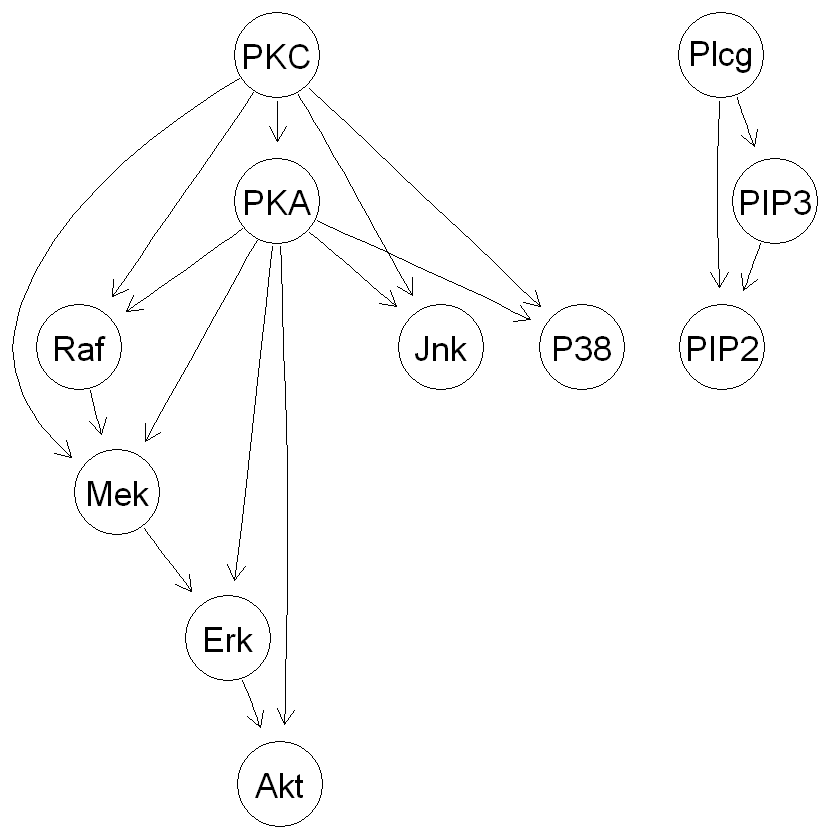

In [11]:
#We get the exact same graph using our algorithm
graphviz.compare(dag.sachs,sachs_net$dag)

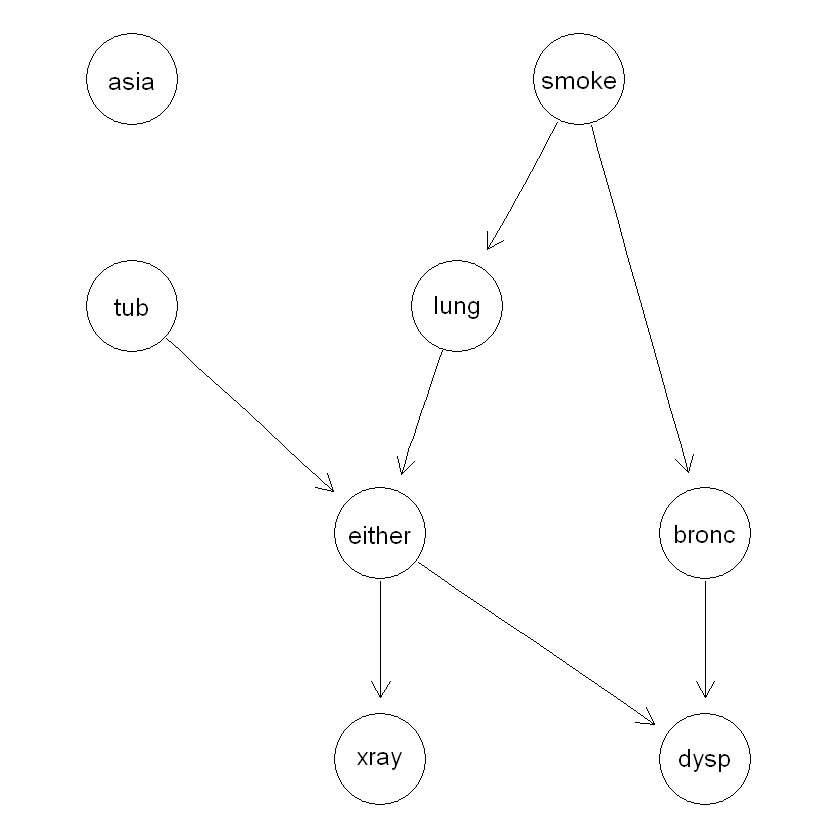

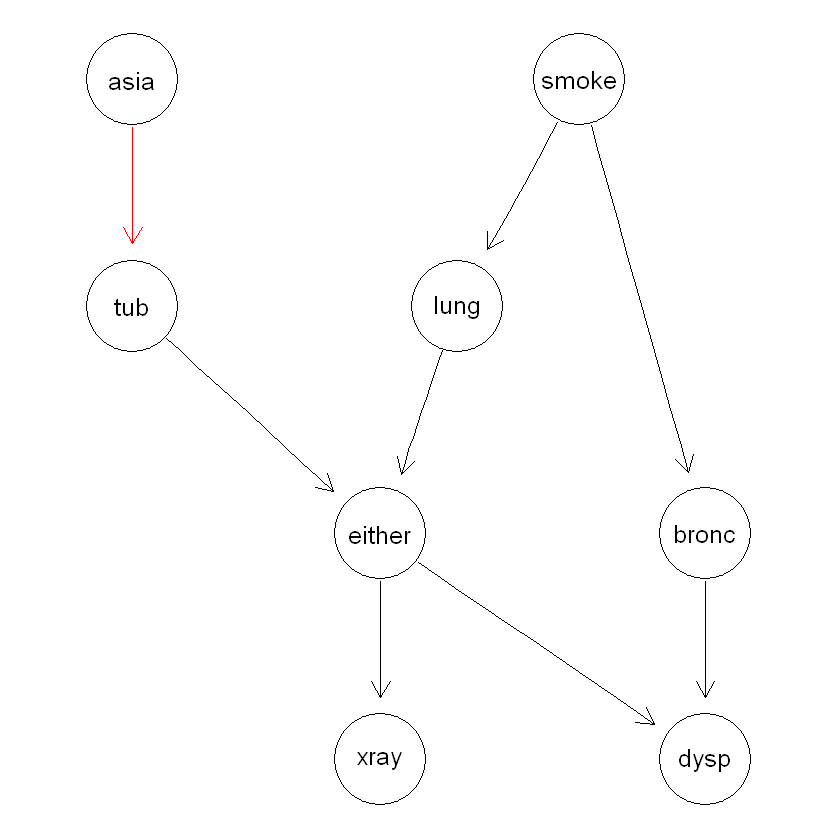

In [12]:
#Our model is only missing one link from asia to tuberculosis
graphviz.compare(asia_net$dag,dag.asia)

<a id='sec3.B'></a>
### **3.B** *Test on SACHS dataset*

We can also see how our performance scales with size using the sachs dataset

In [14]:
df <- data.frame(matrix(ncol = 5, nrow = 0))
colnames(df) <- c("#Samples", "True Positives", "False Positives","False Negatives", "Errors")
    for (i in 1:75) {

        result<- k2(head(sachs,10*i), parents.nmax=2, log.f)
            
            best.dag   <- result$dag
            best.score <- result$score
            total.score<- compare(dag.sachs,best.dag)
        
        df[nrow(df) + 1,] = c(10*i,total.score$tp,total.score$fp,total.score$fn,total.score$fn+total.score$fp)
    }



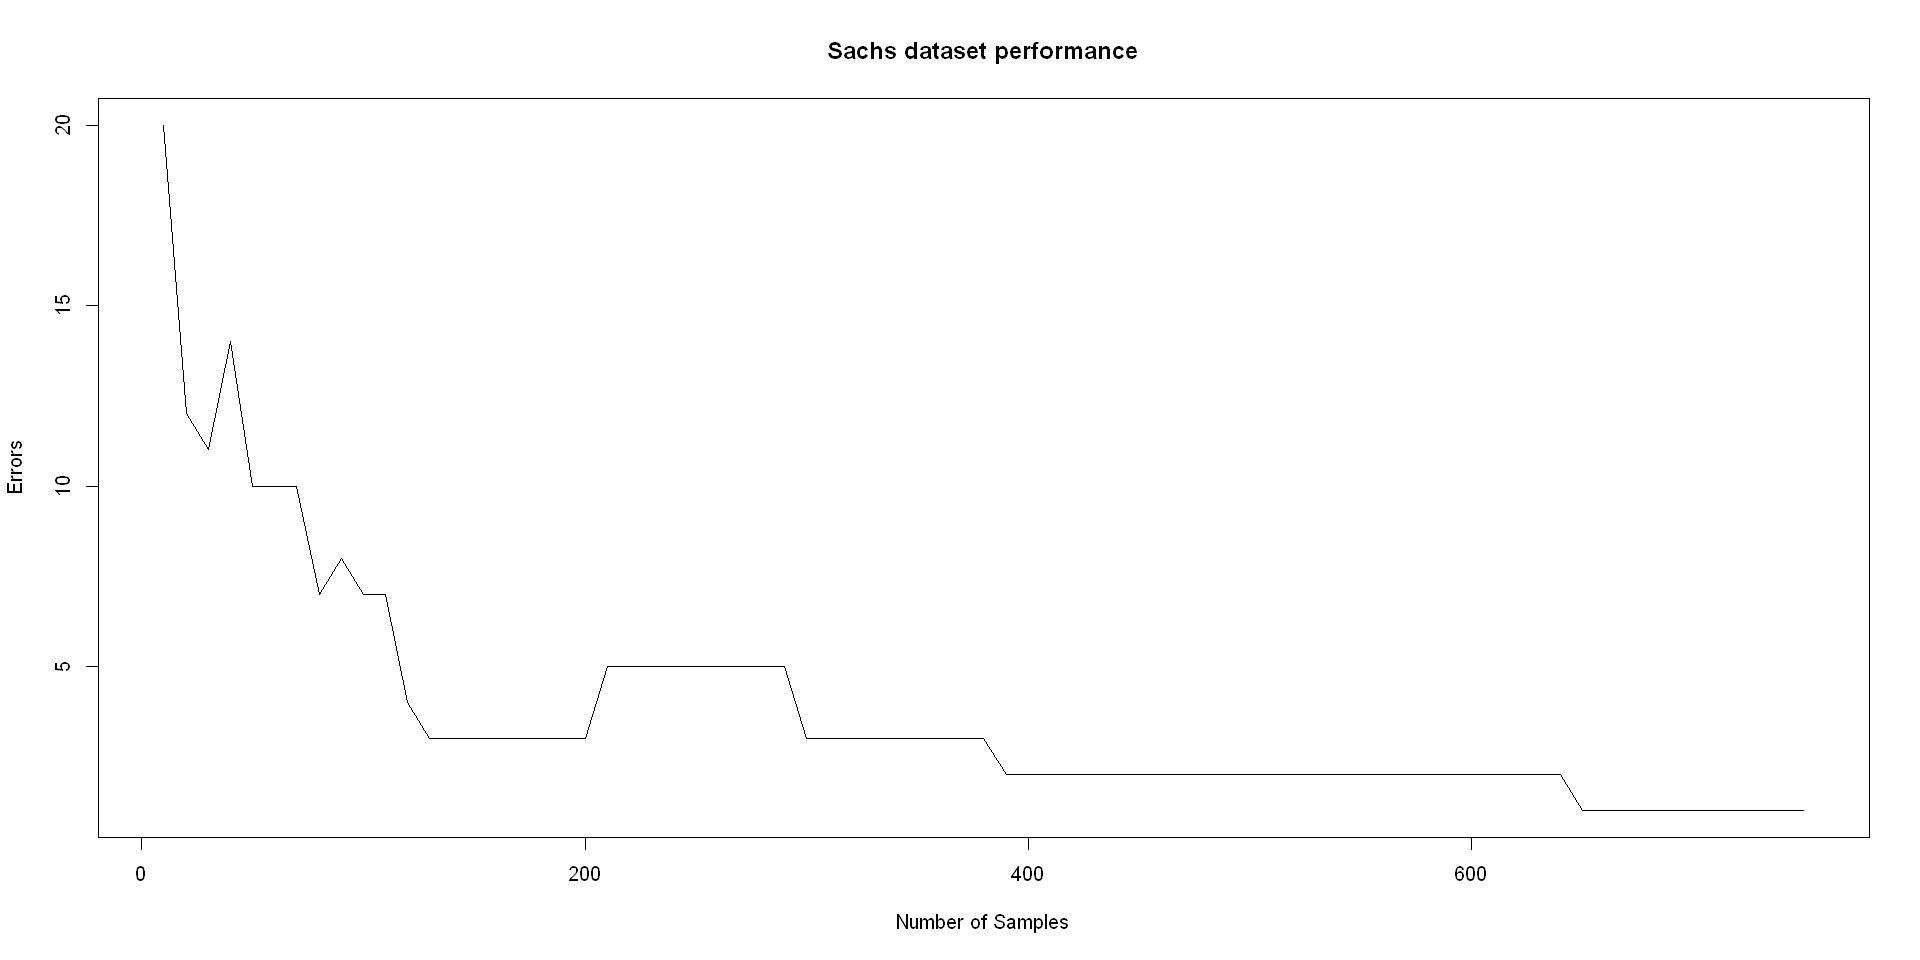

In [15]:
options(repr.plot.width=16, repr.plot.height=8)
plot(df$"#Samples",df$Errors,type="l",ylab="Errors",xlab = "Number of Samples",main="Sachs dataset performance")

<a id='sec3.C'></a>
### **3.C** *Test on ASIA dataset*

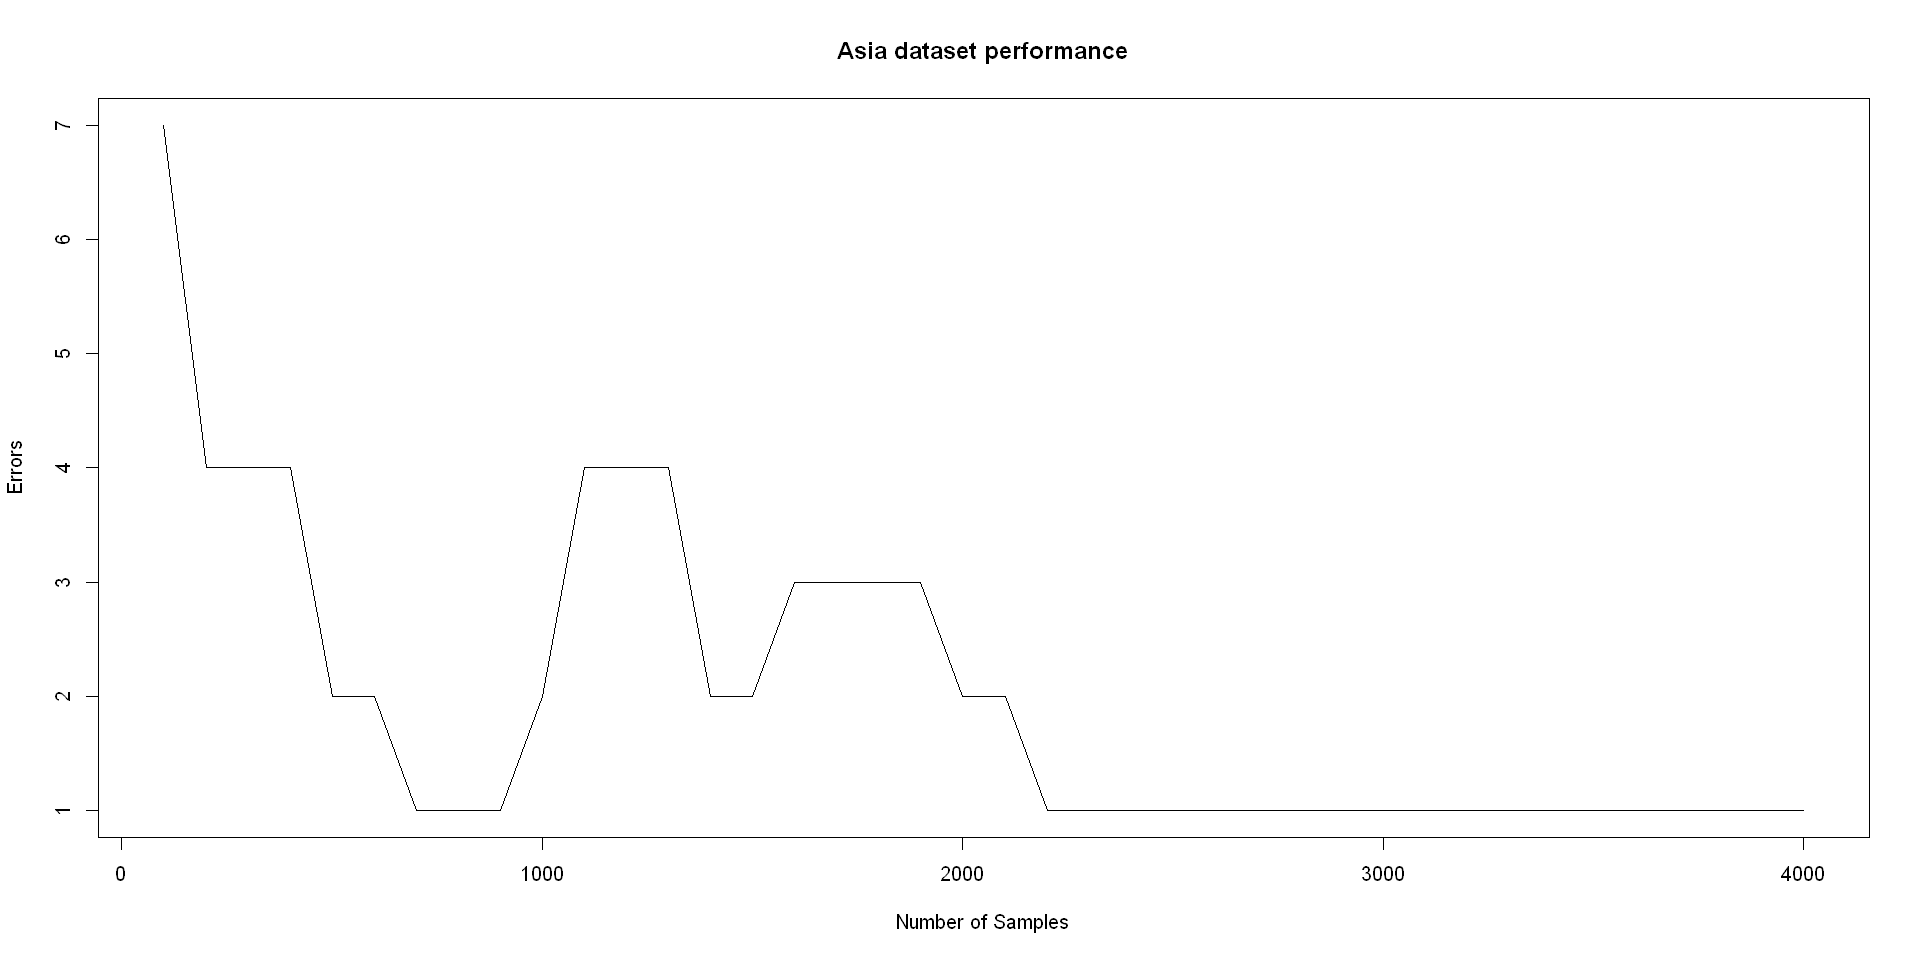

In [16]:
df <- data.frame(matrix(ncol = 5, nrow = 0))
colnames(df) <- c("#Samples", "True Positives", "False Positives","False Negatives", "Errors")
    for (i in 1:40) {

        result<- k2(head(asia,100*i), parents.nmax=2, log.f)
            
            best.dag   <- result$dag
            best.score <- result$score
            total.score<- compare(dag.asia,best.dag)
        
        df[nrow(df) + 1,] = c(100*i,total.score$tp,total.score$fp,total.score$fn,total.score$fn+total.score$fp)
    }

options(repr.plot.width=16, repr.plot.height=8)
plot(df$"#Samples",df$Errors,type="l",ylab="Errors",xlab = "Number of Samples",main="Asia dataset performance")

<a id='sec3.D'></a>
### **3.D** *Comparisons with TABU and HC*

Now we can compare it to other algorithms included in the BNLearn Library. In this case we pick two bnlearn functions. Tabu and HC which are scoring functions.

In [17]:
asia <- read_csv('https://www.ccd.pitt.edu/wiki/images/ASIA10k.csv')
asia[,] <- ifelse(asia == 'yes', 1, 0) 

Rows: 10000 Columns: 8
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ","
chr (8): asia, tub, smoke, lung, bronc, either, xray, dysp

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [23]:

df <- data.frame(matrix(ncol = 7, nrow = 0))
colnames(df) <- c("#Samples", "True Positives", "False Positives","False Negatives", "ErrorsK2","ErrorsHC","ErrorsTabu")
    for (i in 1:100) {

        result<- k2(head(asia,100*i), parents.nmax=2, log.f)
            
            best.dag   <- result$dag
            best.score <- result$score
            total.score<- compare(dag.asia,best.dag)
        
        res <- hc(head(asia,100*i))
            hc.score<- compare(dag.asia,res)
        res <- tabu(head(asia,100*i))
            tabu.score<- compare(dag.asia,res) 
             
        df[nrow(df) + 1,] = c(100*i,total.score$tp,total.score$fp,total.score$fn,total.score$fn+total.score$fp,hc.score$fn+hc.score$fp,tabu.score$fn+tabu.score$fp)
    }


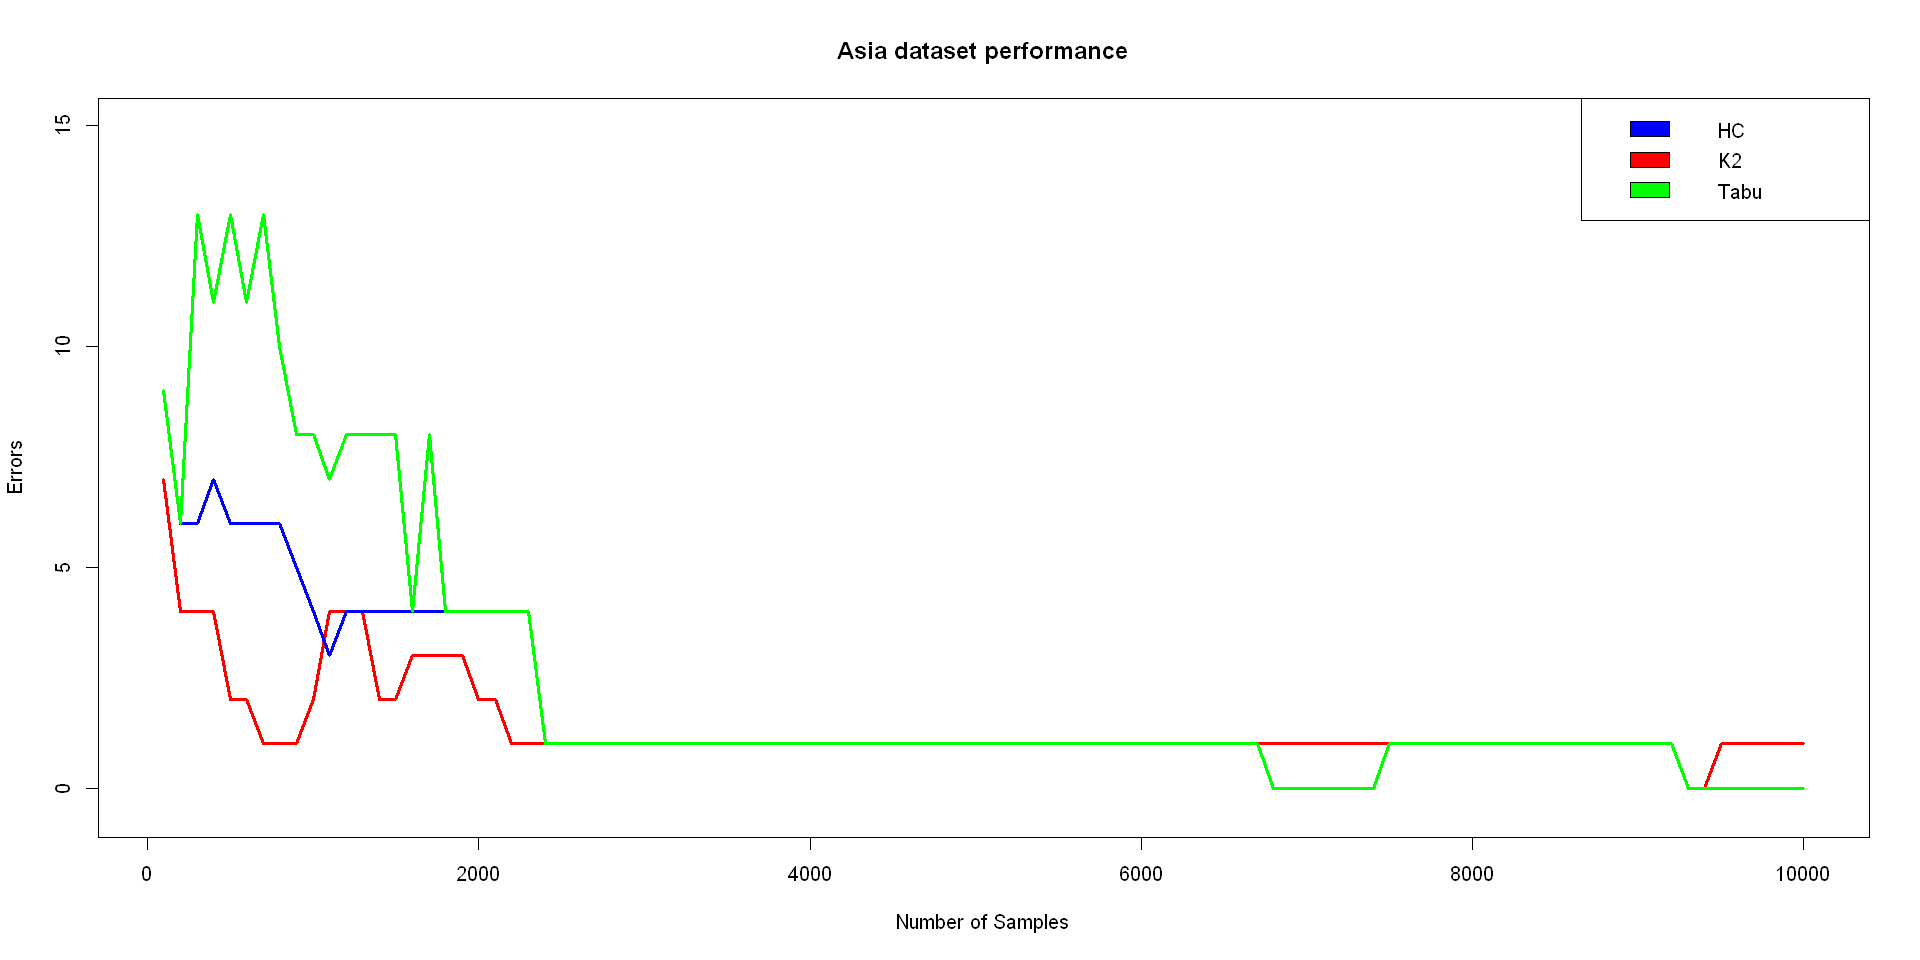

In [24]:
plot(df$"#Samples",df$ErrorsK2,type="l",ylab="Errors",xlab = "Number of Samples",ylim = c(-0.5,15),main="Asia dataset performance",col = "red",lty=1, lwd = 3)
lines(df$"#Samples",df$ErrorsHC,col = "blue",lty=1, lwd = 3)
lines(df$"#Samples",df$ErrorsTabu,col = "green",lty=1, lwd = 3)
legend(1, 4, legend=c("HC", "K2","Tabu"), fill = c("blue","red","green"),x = "topright")


In [20]:
df2 <- data.frame(matrix(ncol = 7, nrow = 0))
colnames(df2) <- c("#Samples", "True Positives", "False Positives","False Negatives", "ErrorsK2","ErrorsHC","ErrorsTabu")
    for (i in 1:75) {

        result<- k2(head(sachs,10*i), parents.nmax=2, log.f)
            
            best.dag   <- result$dag
            best.score <- result$score
            total.score<- compare(dag.sachs,best.dag)
        
        res <- hc(head(sachs,10*i))
            hc.score<- compare(dag.sachs,res)    
        res <- tabu(head(sachs,10*i))
            tabu.score<- compare(dag.sachs,res) 
             
        df2[nrow(df2) + 1,] = c(10*i,total.score$tp,total.score$fp,total.score$fn,total.score$fn+total.score$fp,hc.score$fn+hc.score$fp,tabu.score$fn+tabu.score$fp)
    }


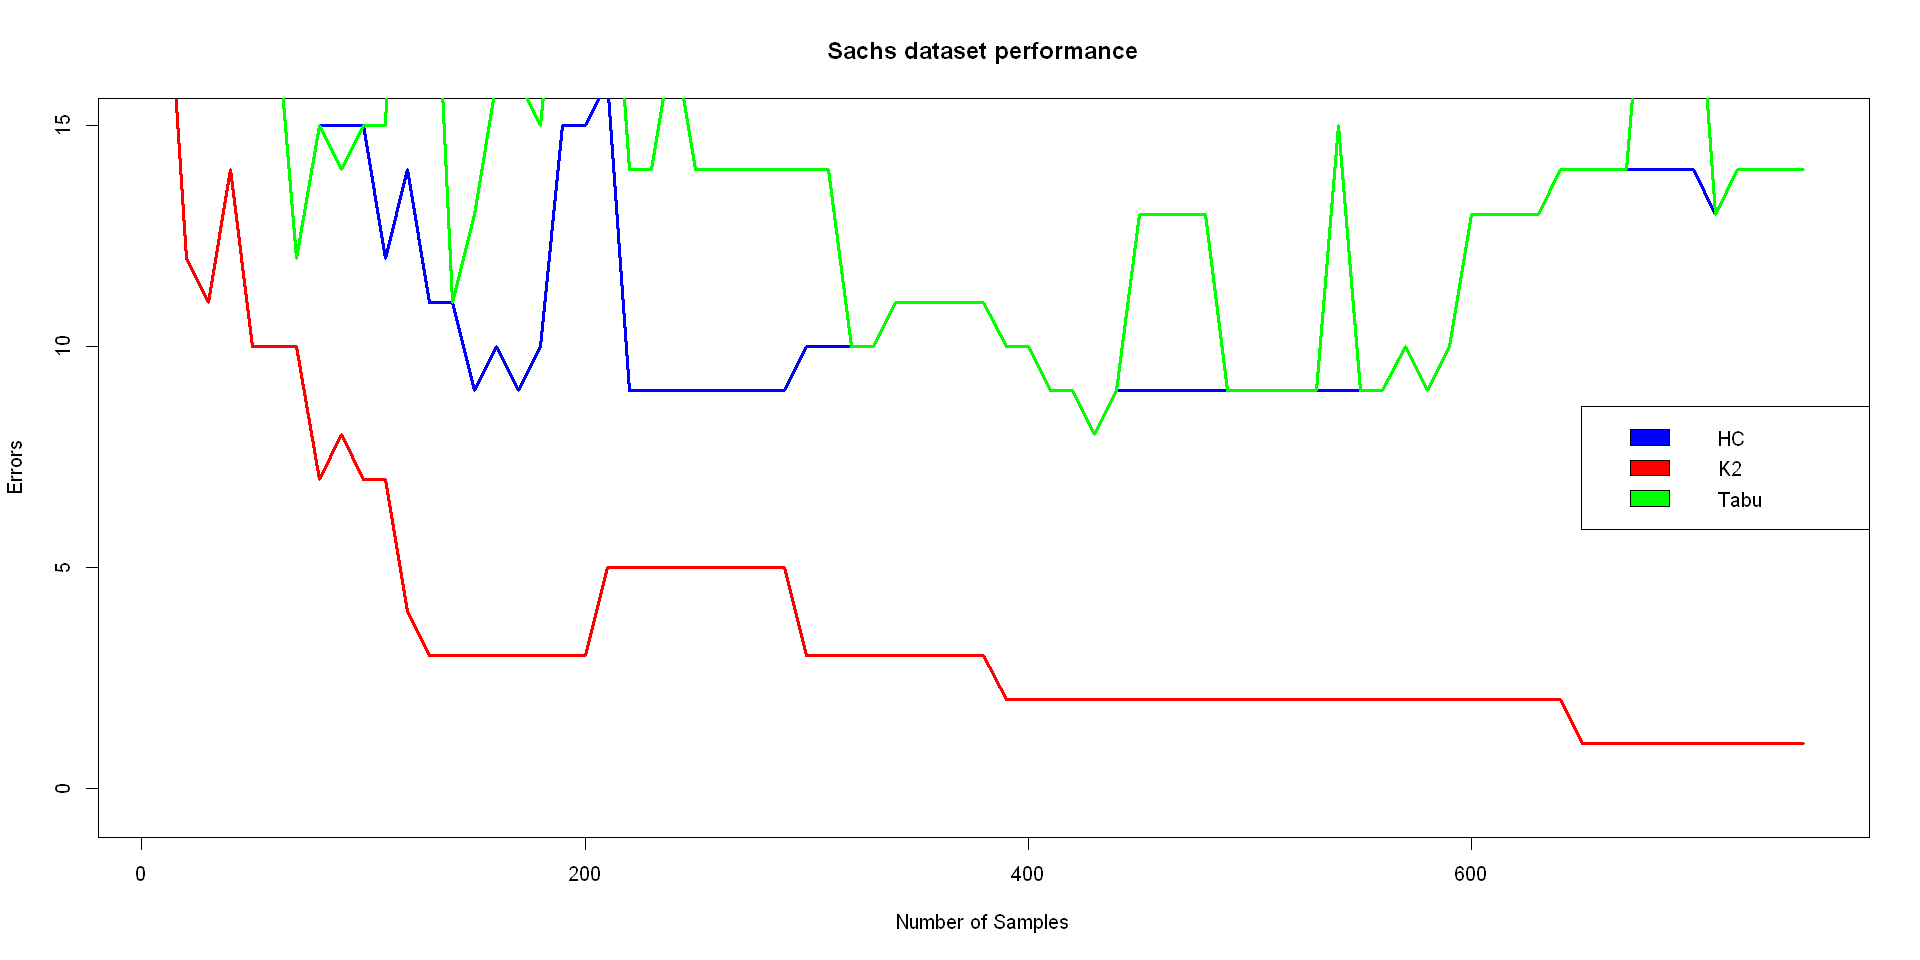

In [22]:
plot(df2$"#Samples",df2$ErrorsK2,type="l",ylab="Errors",xlab = "Number of Samples",ylim = c(-0.5,15),main="Sachs dataset performance",col = "red",lty=1, lwd = 3)
lines(df2$"#Samples",df2$ErrorsHC,col = "blue",lty=1, lwd = 3)
lines(df2$"#Samples",df2$ErrorsTabu,col = "green",lty=1, lwd = 3)
legend(1, 4, legend=c("HC", "K2","Tabu"), fill = c("blue","red","green"),x = "right")

As we can see, the ASIA dataset is solved in the same way for the 3 algorithms but the Sachs dataset exhibits different solutions for the 3 algorithms

## **References**

<a id='ref1'></a>
**[1]** M. Scutari and J. B. Denis, *Bayesian Networks*, CRC Press, 2022, Taylor and Francis Group

<a id='ref2'></a>
**[2]** G. F. Cooper and E. Herskovits, *A Bayesian Method for the Induction of Probabilistic Networks from Data*, Machine Learning 9, (1992) 309

<a id='ref3'></a>
**[3]** C. Ruiz, *Illustration of the K2 Algorithm for learning Bayes Net Structures*, http://web.cs.wpi.edu/~cs539/s11/Projects/k2_algorithm.pdf

<a id='ref4'></a>
**[4]** M. Scutari., *Score-based structure learning algorithms*, https://www.bnlearn.com/documentation/man/hc.html

<a id='ref5'></a>
**[5]** A. Franzin et al., *$\texttt{bnstruct}$: an R package for Bayesian Network structure learning in the presence of missing data*, Bioinformatics 33(8) (2017) 1250

<a id='ref6'></a>
**[6]** F. Sambo and A. Franzin, *$\texttt{bnstruct}$: an R package for Bayesian Network Structure Learning with missing data*, December 12, 2016

***

Code by *Gianmarco Nagaro*, last review: 13 July 2022 <br>**Workgroup**: Barone Francesco, Nagaro Gianmarco, Ninni Daniele.

University of Padua, **Advanced Statistics for Physics Analysis**.